- Lihua Xiong, lx559

<h1><center>ICA Project</center></h1>
<h2><center>Stabilizing The Factors</center></h2>

## Objective
In this project you will use ICA and and Truncated PCA methods in order to find more stable covariance and correlation factors for intraday stock returns.

## Data
In this project, you will use the Nasdaq 100 intraday stock 1 minute bars. From the same dataset, you will also construct 5-minute, 15-minute and 30-minute bars.

## Motivation
Stock prices are known to become less-Gaussian at higher frequencies (e.g. see for example sec 2.4 in [Bouchaud and Potters' book](https://www.amazon.com/Theory-Financial-Risk-Derivative-Pricing/dp/0521819164), an evaluation version of which can be found [here](http://www.math.ku.dk/~rolf/Klaus/bouchaud-book.ps.pdf)). Even at daily frequencies, however, it is known that stock returns exhibit skewness which deviates from Gaussianity. In fact, most stock's volatility is known to be stochastic and negatively correlated with the spot price. Even the correlation between the spot and its volatility [seems to switch between regimes](http://www.javaquant.net/papers/derman_1999_regimes.pdf), and in addition it can vary from stock to stock.  At intraday frequencies, the stock distribution tends to become a bit more symmetric, but its [kurtosis becomes more anomalous](http://www.math.ku.dk/~rolf/Klaus/bouchaud-book.ps.pdf) giving rise to fatter tails. Moreover the volatility at intraday levels has a pronounced intraday pattern, with a spike at the beginning of the trading day and relaxation towards the end. 

It is well known that the stocks' empirical covariance and correlation matrices both have at least one significant factors. If one then believes that the returns of a given universe of stocks ${\bf R}_t=(r_{1,t},...,r_{N,t})^T\in{R}^N$ can be written as:
$$
{\bf R}_t = {\bf \bar{R}} + {\bf \beta}{\bf R^F}_t  + {\bf \varepsilon}_t
$$
Then the non-Gaussianity of individual stocks ${\bf R}_t$ either comes from the idiosyncratic component ${\varepsilon}_t$ or from at least some of the factors ${\bf R}^F_t\in{R}^K$ or from both. If we demean and normalize the returns to be of unit variance, and moreover <font color='red'>**absorb the factor variance into the loadings ${\bf \beta}$**</font>, the above equation becomes the exact starting point of ICA. 

The only difference would be that ${\bf R}$ is $N$-dimensional and ${\bf R^F}$ is $K$-dimensional. Do we <font color='red'>**subsample**</font> $K$ stocks in order to estimate ICA?

## Methodology and Deliverables

Submit all your code in the 'datasets/all_remaining_projects/ica_factors/' directory.

Assume we have $\bar{K}\leq{K}\ll{N}$ non-Gaussian factors at a given frequency. 
- For each of the frequencies $f=\{1, 2, 5, 15, 30\}$-min choose the total number of training bars to be $T=75$. For $1$-min bars this would correspond to less than $1/5$ of the trading day; for $5$-min bars this would be almost a full trading day, etc. 

Note that because we have $N=100$ stocks, the empirical covariance will not be full rank. However we can still perform **rank-$K$ truncated SVD** on the (standardized and demeaned) returns:
$$
{\bf R} = {\bf U_{T\times{K}}D_KV^T_{N\times{K}}}
$$
and interpret ${\bf\hat{R}_F^T\equiv{D^{-1/2}}{V}^T{R}^T}$ as the time-series of matrix of $K$ univariate factors. The matrix ${\bf V}$ represents the $K$ factor portfolios where the factor weights of the $k$-th portfolio are have unit $l_2$ norm, $|{\bf v}_k|^2 = 1$.

### Part I: Data preprocessing

- Generate $f=\{2, 5, 15, 30\}$-min bars from 1min bars.
- The data is stored under datasets/taq_ndx100/Pickles/ folder, with naming convention: ticker_ohlcv_freq.pkl

In [1]:
import pandas as pd
import os

In [2]:
#meta parameters
path = '/Users/xionglihua/Google Drive/datasets/taq_ndx100/Pickles/'
path_text = '/Users/xionglihua/Google Drive/datasets/taq_ndx100/'
path_ica = '/Users/xionglihua/Google Drive/datasets/all_remaining_projects/ica_factors/'
path_outer = path_text + "trades/"

**Load an example dataset:**

In [233]:
df = pd.read_pickle(path+'AMZN_ohlcv_1min.pkl')

In [234]:
df.head()

,open,high,low,close,volume
TIME_STAMP,,,,,
2016-03-01 04:00:00,553.0,553.0,553.0,553.0,15.0
2016-03-01 04:01:00,NaN,NaN,NaN,NaN,NaN
2016-03-01 04:02:00,NaN,NaN,NaN,NaN,NaN
2016-03-01 04:03:00,NaN,NaN,NaN,NaN,NaN
2016-03-01 04:04:00,NaN,NaN,NaN,NaN,NaN


**Fill in the NaN:**

Methodology
- for the prices: fill in NaN with last non-NaN value
- for the volume: fill in NaN with 0

In [182]:
df['volume'] = df['volume'].fillna(0)
df = df.fillna(method='ffill').between_time('09:00', '16:30')
df.head(10)

,open,high,low,close,volume
TIME_STAMP,,,,,
2016-03-01 09:00:00,557.85,557.85,557.85,557.85,25.0
2016-03-01 09:01:00,557.85,558.00,557.77,557.77,437.0
2016-03-01 09:02:00,557.75,557.75,552.52,552.52,104.0
2016-03-01 09:03:00,552.52,552.52,552.52,552.52,2.0
2016-03-01 09:04:00,552.52,552.52,552.52,552.52,0.0
2016-03-01 09:05:00,552.52,552.52,552.52,552.52,0.0
2016-03-01 09:06:00,557.75,557.75,557.75,557.75,500.0
2016-03-01 09:07:00,558.00,558.00,557.50,557.50,350.0
2016-03-01 09:08:00,558.00,558.00,557.50,557.50,0.0


**Resample by 2 min:**

In [183]:
temp = pd.DataFrame()
temp['open'] = df.resample('2T').ohlc()['open']['open']
temp['high'] = df.resample('2T').ohlc()['high']['high']
temp['low'] = df.resample('2T').ohlc()['low']['low']
temp['close'] = df.resample('2T').ohlc()['close']['close']
temp['volume'] = df.resample('2T').volume.apply(sum)
temp.head()

,open,high,low,close,volume
TIME_STAMP,,,,,
2016-03-01 09:00:00,557.85,558.00,557.77,557.77,462.0
2016-03-01 09:02:00,557.75,557.75,552.52,552.52,106.0
2016-03-01 09:04:00,552.52,552.52,552.52,552.52,0.0
2016-03-01 09:06:00,557.75,558.00,557.50,557.50,850.0
2016-03-01 09:08:00,558.00,558.00,557.50,558.00,40.0


We could validate the methodology by comparing the 2 charts above.

Then we could apply this methodology iteratively to all of the tickers & frequencies.

In [109]:
#create series with all the relevant ticker names
file_ = path_text + 'ndx100.txt'
dftext = pd.read_table(file_, delimiter=',',escapechar="\n",header=-1)
freqs = ['1T','2T', '5T', '15T', '30T']

In [110]:
def create_bar(df, ticker, freq):
    temp = pd.DataFrame()
    temp['open'] = df.resample(freq).ohlc()['open']['open']
    temp['high'] = df.resample(freq).ohlc()['high']['high']
    temp['low'] = df.resample(freq).ohlc()['low']['low']
    temp['close'] = df.resample(freq).ohlc()['close']['close']
    temp['volume'] = df.resample(freq).volume.apply(sum)
    temp.to_pickle(path_ica + 'data/' + ticker + '_ohlcv_' + freq[:-1] + 'min.pkl')
    print( ticker + ' ' + freq[:-1] + 'min file created')

In [123]:
for index, row in dftext.iterrows():
    ticker =  row[0]
    # load file
    file_name = ticker + '_ohlcv_1min.pkl' 
    if(os.path.isfile(path + file_name)):
        df = pd.read_pickle(path + file_name)
    else:
        # FAST doesn't exist.
        print(path + file_name + " doesn't exist.")
        continue;
        
    # CMCSA, GOOGL, LBTYA, LBTYK, LVNTA is empty
    if len(df)>0:
        # fill in NaN
        df['volume'] = df['volume'].fillna(0)
        df = df.fillna(method='ffill').between_time('09:00', '16:30')
        for freq in freqs:
            # create bar using cleaned file
            create_bar(df, ticker, freq)
    else:
        print(file_name + " is empty.")

/Users/xionglihua/Google Drive/datasets/taq_ndx100/Pickles/FAST_ohlcv_1min.pkl doesn't exist.
FB 1min file created
FB 2min file created
FB 5min file created
FB 15min file created
FB 30min file created
FISV 1min file created
FISV 2min file created
FISV 5min file created
FISV 15min file created
FISV 30min file created
FOX 1min file created
FOX 2min file created
FOX 5min file created
FOX 15min file created
FOX 30min file created
FOXA 1min file created
FOXA 2min file created
FOXA 5min file created
FOXA 15min file created
FOXA 30min file created
GILD 1min file created
GILD 2min file created
GILD 5min file created
GILD 15min file created
GILD 30min file created
GOOG 1min file created
GOOG 2min file created
GOOG 5min file created
GOOG 15min file created
GOOG 30min file created
GOOGL_ohlcv_1min.pkl is empty.
HSIC 1min file created
HSIC 2min file created
HSIC 5min file created
HSIC 15min file created
HSIC 30min file created
INCY 1min file created
INCY 2min file created
INCY 5min file created
IN

### Part II: $l_2$ Overlap analysis
- For each of the frequencies above
    - choose a sequence of $M$ or more non-overlapping mini-batch time periods, each starting from the same time of the trading day
    - for each mini-batch period $m$ calculate the time-series of the $K$ covariance factors and their corresponding $l_2$ portfolios

In [3]:
path_ovl = path_ica + 'data/'
# the list of tickers: totally 96
file_ = path_ica + 'ndx100.txt'
dftext = pd.read_table(file_, delimiter=',',escapechar="\n",header=-1)
# frequencies
freqs = ['1min', '2min', '5min', '15min', '30min']

**First**, we get returns between trading hours for all stocks at certain frequency in one file.

In [5]:
# get returns for all stocks at certain frequency 
def get_return(freq):
    R = pd.DataFrame()
    for index, row in dftext.iterrows():
        ticker = row[0]
        file_path = path_ovl + ticker + '_ohlcv_' + freq + '.pkl'
        df = pd.read_pickle(file_path)
        # Calculate return
        df['return'] = df['close'] - df['open']
        # Get return between trading hours
        r = df.between_time('09:30:00', '16:00:00')['return']
        R[ticker] = r
    # Here we may also get NaNs because of lack of trading data
    # fill in it with 0      
    R = R.fillna(0)
    R.to_pickle(path_ica + 'Returns_' + freq + '.pkl')
    return R

In [6]:
R1 = get_return('1min')
R2 = get_return('2min')
R5 = get_return('5min')
R15 = get_return('15min')
R30 = get_return('30min')

In [167]:
# check if there's NaN
R30.isnull().any().any()

False

**Second**, we process the batch.

In [7]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
from datetime import date, time, datetime, timedelta

In [93]:
def process_batch(freq, start='09:30:00', T=75):
    # read in returns
    R = pd.read_pickle(path_ica + 'Returns_' + freq + '.pkl')
    
    # get all the starting index
    start = pd.to_datetime(start)
    end = start + timedelta(seconds=1)
    start = start.strftime("%H:%M:%S")
    end = end.strftime("%H:%M:%S")
    allStartTimes = R.between_time(start, end).index
    allStartIndex = [R.index.get_loc(item) for item in allStartTimes]
    # Note: drop those inside the minibatch
    StartIndex = []
    StartTimes = []
    for i in range(len(allStartIndex)):
        if i == 0:
            StartIndex.append(allStartIndex[i])
            StartTimes.append(allStartTimes[i])
            lastIndex = 0
            continue;
            
        if allStartIndex[i] - allStartIndex[lastIndex] < T:
            # not appending anything
            continue;
        else:
            StartIndex.append(allStartIndex[i])
            StartTimes.append(allStartTimes[i])
            lastIndex = i
            
    if (StartIndex[-1] + T) > len(R):
        StartIndex =  StartIndex[:-1]
        StartTimes =  StartTimes[:-1]
            
    # Store the StartTimes for each frequency
    a = [item.strftime('%F %T').replace(':','-') for item in StartTimes]
    pd.DataFrame(a).to_csv(path_ica+'StartTimes_'+start.replace(':','-')+'_'+freq+'.csv')
    
    # iterate over all the start index
    for j in range(len(StartIndex)):
        # get batch of size T
        batch = R.iloc[StartIndex[j] : (StartIndex[j]+T)]
        # demean the return
        batch = batch - batch.mean()
        # truncated svd: K = 74
        svd = TruncatedSVD(
            n_components=min(batch.shape)-1,
            random_state=42,
            algorithm='arpack'
        )
        batch_trans = svd.fit_transform(batch)
        VT = svd.components_
        # each column of V is the factor weights of the k-th portfolio
        # unit L2 norm
        # N by K matrix
        V = VT.T
        D = svd.singular_values_
        # time series of K factors
        # T by K
        # each column corresponds to a factor
        RF = np.dot(np.dot(np.diag(np.reciprocal(np.sqrt(D))),VT),batch.T).T
        # store batch, RF and V
        file_name = StartTimes[j].strftime('%F %T').replace(':','-') + '_' + freq + '.pkl'
        pd.DataFrame(batch).to_pickle(path_ica + 'batch/' + file_name)
        pd.DataFrame(RF).to_pickle(path_ica + 'RF/' + file_name)
        pd.DataFrame(V).to_pickle(path_ica + 'V/' + file_name)
    print('Finished processing: ' + freq + ' starting at ' + start)

In [64]:
for freq in freqs:
    process_batch(freq, start='09:30:00', T=75)
print('Finished processing all.')   

/Users/xionglihua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/decomposition/truncated_svd.py:188: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/xionglihua/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in reciprocal
/Users/xionglihua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/decomposition/truncated_svd.py:188: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Finished processing: 1min starting at 09:30:00
Finished processing: 2min starting at 09:30:00
Finished processing: 5min starting at 09:30:00
Finished processing: 15min starting at 09:30:00
Finished processing: 30min starting at 09:30:00
Finished processing all.


In [65]:
process_batch('1min', start='10:45:00', T=75)
process_batch('1min', start='12:00:00', T=75)
process_batch('1min', start='13:15:00', T=75)
process_batch('1min', start='14:30:00', T=75)
process_batch('2min', start='12:00:00', T=75)
process_batch('2min', start='14:30:00', T=75)

/Users/xionglihua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/decomposition/truncated_svd.py:188: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/xionglihua/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in reciprocal
/Users/xionglihua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/decomposition/truncated_svd.py:188: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Finished processing: 1min starting at 10:45:00
Finished processing: 1min starting at 12:00:00
Finished processing: 1min starting at 13:15:00
Finished processing: 1min starting at 14:30:00
Finished processing: 2min starting at 12:00:00
Finished processing: 2min starting at 14:30:00


**Note:** 

All the data needed for follwing analysis is stored under the ica_factors folder.

- ../batch/ contains all the mini-batches.
- ../RF/ contains the time series of factors.
- ../V/ contains factor portfolios.

The naming convention is consistently as follows:

“YYYY-MM-DD HH-MM-SS_fmin.pkl"

e.g. “2016-03-01 09-30-00_1min.pkl” represents the information of 2016-03-01 starting at 09:30:00 with 1min frequency.

**Third,** we proceed to the analysis.

- for each consecutive periods $m, m+1$ calculate the $l_2$ overlap between the $k$-th covariance portfolio at period $m$ and that at period $m + 1$. What do the time series of these overlaps look like as a function of the factor rank $k$? Explain your observations.

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

In [148]:
start = '09:30:00'
freq_data = []
for freq in freqs:
    #print(freq)
    # read in the batch names
    batch_names = pd.read_csv(path_ica+'StartTimes_'+start.replace(':','-')+'_'+freq+'.csv')
    batch_names = batch_names['0']
    nNames = len(batch_names)
    # record the times series of L2 overlap
    series = []
    for m in range(nNames-1):
        #print(m)
        # N by K
        cur = pd.read_pickle(path_ica+'V/'+batch_names[m]+'_'+freq+'.pkl')
        nex = pd.read_pickle(path_ica+'V/'+batch_names[m+1]+'_'+freq+'.pkl')
        (N, K) = cur.shape
        # record L2 overlap for k factors at step m
        cos_m = []
        for i in range(K):
            ci = cur.iloc[:,i].values.reshape(1,N)
            ni = nex.iloc[:,i].values.reshape(1,N)
            ci[np.isnan(ci)] = 0
            ni[np.isnan(ni)] = 0
            cos = cosine_similarity(ci,ni)[0][0]
            cos_m.append(cos)
        series.append(cos_m)
    freq_data.append(series)

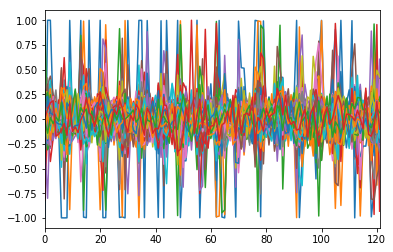

In [149]:
%matplotlib inline
# freq = '1min'
ax = pd.DataFrame(freq_data[0]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'V_1min.png')

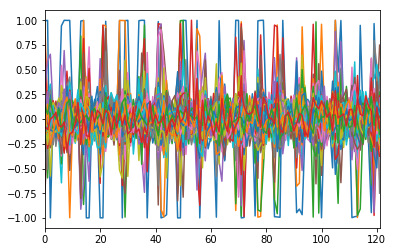

In [150]:
# freq = '2min'
ax = pd.DataFrame(freq_data[1]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'V_2min.png')

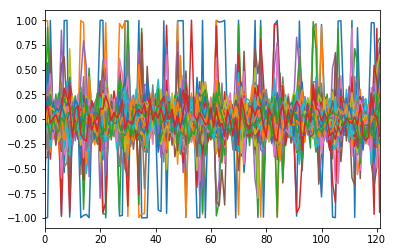

In [151]:
# freq = '5min'
ax = pd.DataFrame(freq_data[2]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'V_5min.png')

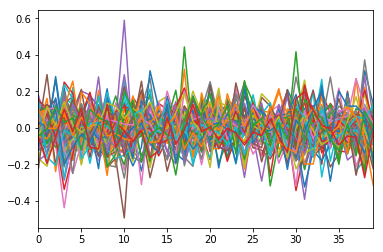

In [152]:
# freq = '15min'
ax = pd.DataFrame(freq_data[3]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'V_15min.png')

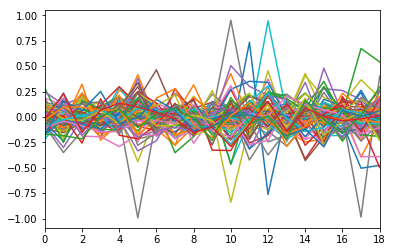

In [153]:
# freq = '30min'
ax = pd.DataFrame(freq_data[4]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'V_30min.png')

If we plot RF further, we could get more obvious results.

In [134]:
start = '09:30:00'
freq_data = []
for freq in freqs:
    #print(freq)
    # read in the batch names
    batch_names = pd.read_csv(path_ica+'StartTimes_'+start.replace(':','-')+'_'+freq+'.csv')
    batch_names = batch_names['0']
    nNames = len(batch_names)
    # record the times series of L2 overlap
    series = []
    for m in range(nNames-1):
        #print(m)
        # N by K
        cur = pd.read_pickle(path_ica+'RF/'+batch_names[m]+'_'+freq+'.pkl')
        nex = pd.read_pickle(path_ica+'RF/'+batch_names[m+1]+'_'+freq+'.pkl')
        (N, K) = cur.shape
        # record L2 overlap for k factors at step m
        cos_m = []
        for i in range(K):
            ci = cur.iloc[:,i].values.reshape(1,N)
            ni = nex.iloc[:,i].values.reshape(1,N)
            ci[np.isnan(ci)] = 0
            ni[np.isnan(ni)] = 0
            cos = cosine_similarity(ci,ni)[0][0]
            cos_m.append(cos)
        series.append(cos_m)
    freq_data.append(series)

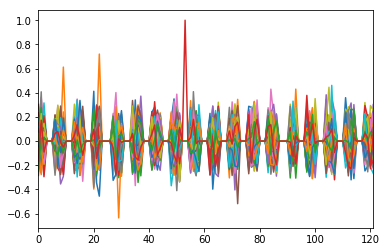

In [140]:
# freq = '1min'
ax = pd.DataFrame(freq_data[0]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'RF_1min.png')

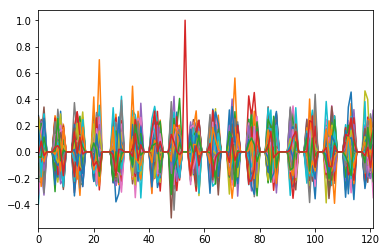

In [141]:
# freq = '2min'
ax = pd.DataFrame(freq_data[1]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'RF_2min.png')

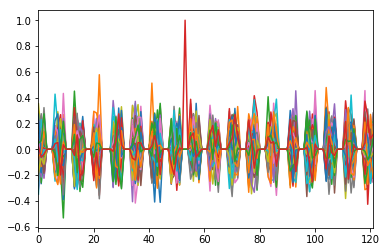

In [142]:
# freq = '5min'
ax = pd.DataFrame(freq_data[2]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'RF_5min.png')

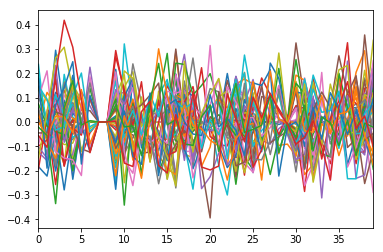

In [143]:
# freq = '15min'
ax = pd.DataFrame(freq_data[3]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'RF_15min.png')

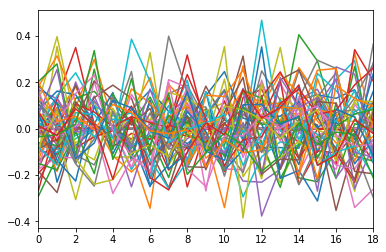

In [144]:
# freq = '30min'
ax = pd.DataFrame(freq_data[4]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'RF_30min.png')

**Conclusion:** 

There's periodic pattern for the portfolios. The period is between 1-3days.

- For $1$-min and $2$-min returns we can calculate also overlap between factor portfolios at different parts of the day. What is the overlap between $k-$th factor at the beginning vs middle vs end of the day? Explain your observations.

In [154]:
start_1 = ['09:30:00', '10:45:00', '12:00:00', '13:15:00', '14:30:00']
start_2 = ['09:30:00', '12:00:00', '14:30:00']

In [166]:
def get_intraday(freq, start_1, mark = 'V/'):
    all_data = []
    nStart = len(start_1)
    for i in range(nStart-1):
        #print(freq)
        # read in the batch names
        start1 = start_1[i]
        start2 = start_1[i+1]
        batch_names_1 = pd.read_csv(path_ica+'StartTimes_'+start1.replace(':','-')+'_'+freq+'.csv')['0']
        batch_names_2 = pd.read_csv(path_ica+'StartTimes_'+start2.replace(':','-')+'_'+freq+'.csv')['0']
        nNames = len(batch_names_1)
        # record the times series of L2 overlap
        series = []
        for m in range(nNames):
            #print(m)
            # N by K
            cur = pd.read_pickle(path_ica+mark+batch_names_1[m]+'_'+freq+'.pkl')
            nex = pd.read_pickle(path_ica+mark+batch_names_2[m]+'_'+freq+'.pkl')
            (N, K) = cur.shape
            # record L2 overlap for k factors at step m
            cos_m = []
            for i in range(K):
                ci = cur.iloc[:,i].values.reshape(1,N)
                ni = nex.iloc[:,i].values.reshape(1,N)
                ci[np.isnan(ci)] = 0
                ni[np.isnan(ni)] = 0
                cos = cosine_similarity(ci,ni)[0][0]
                cos_m.append(cos)
            series.append(cos_m)
        all_data.append(series)
    return all_data

In [167]:
data_1 = get_intraday('1min',start_1)

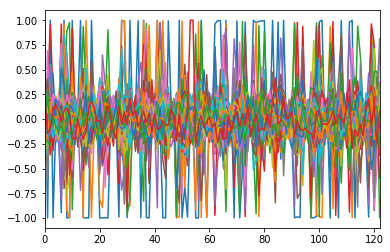

In [168]:
#09:30:00', '10:45:00'
ax = pd.DataFrame(data_1[0]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'Intraday_1min_0.png')

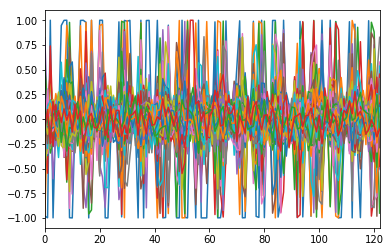

In [169]:
#'10:45:00', '12:00:00'
ax = pd.DataFrame(data_1[1]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'Intraday_1min_1.png')

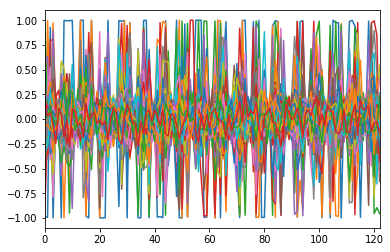

In [170]:
#'12:00:00', '13:15:00'
ax = pd.DataFrame(data_1[2]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'Intraday_1min_2.png')

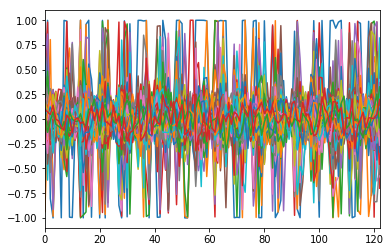

In [171]:
#'13:15:00', '14:30:00'
ax = pd.DataFrame(data_1[3]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'Intraday_1min_3.png')

In [173]:
data_2 = get_intraday('1min',start_2)

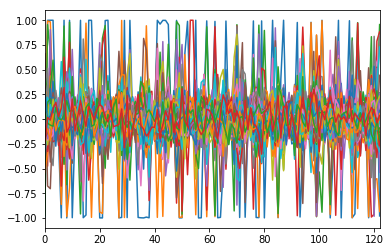

In [174]:
#09:30:00', '12:00:00'
ax = pd.DataFrame(data_2[0]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'Intraday_2min_0.png')

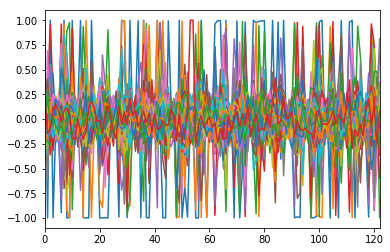

In [175]:
#12:00:00', '14:30:00'
ax = pd.DataFrame(data_1[0]).plot(legend=False)
fig = ax.get_figure()
fig.savefig(path_ica + 'PartI/'+'Intraday_1min_0.png')

**Conclusion:**

We could also see periodic pattern here. The period smaller than the cross-day period.